## Titanic - Predicting Survival

This is about predicting whether a passenger survived the sinking of the Titanic or not

#### The Dataset:

    PassengerID - A column added by Kaggle to identify each row and make submissions easier
    Survived - Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)
    Pclass - The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)
    Sex - The passenger's sex
    Age - The passenger's age in years
    SibSp - The number of siblings or spouses the passenger had aboard the Titanic
    Parch - The number of parents or children the passenger had aboard the Titanic
    Ticket - The passenger's ticket number
    Fare - The fare the passenger paid
    Cabin - The passenger's cabin number
    Embarked - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)


In [95]:
import types
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
train = pd.read_csv("train.csv")

In [97]:
test = pd.read_csv("test.csv")

In [98]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [99]:
sum(test.isnull().any())

3

#### We can see that 3 columns contain missing values in the test set - let's investigate.

In [100]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


#### While the 1 missing value in Fare is neglibible, Cabin and Age are significant and approaches have to be developed to fill in or drop.

In [101]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [102]:
sum(train.isnull().any())

3

In [103]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### For the train data we see a similar picture for AGe and Cabin, with the difference that we have two missing values for Embarked.

#### Let's start exploring first to see which approaches for filling in missing values and which transformations have to be done.

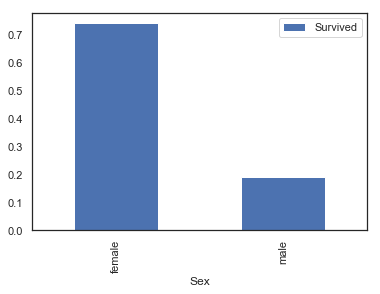

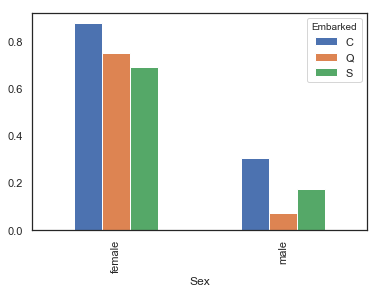

In [104]:
sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.style
plt.show()

sex_pivot = train.pivot_table(index="Sex",values="Survived", columns="Embarked")
sex_pivot.plot.bar()
plt.show()

#### We can cleary see that it was benefical to be female and we can see that it raises survival rate to enter in Cherbourg for both sexes. This might be related to social status and we'll see that later. It cant explain the low rate for males entering in Queensborough.

In [105]:
train["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

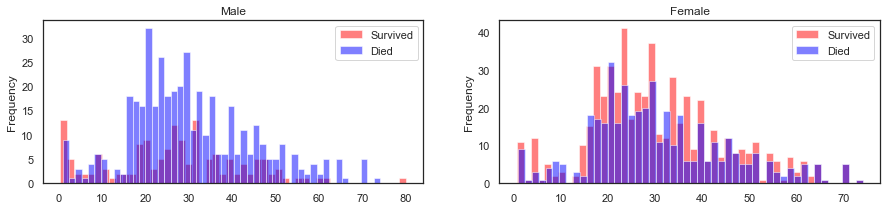

In [106]:
plt.figure(figsize=(15,3))
plt.subplot(1, 2, 1)
survived = train[(train["Survived"]) == 1 & (train["Sex"]=="male")]
died = train[(train["Survived"]) == 0 & (train["Sex"]=="male")]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.title("Male")
plt.legend(['Survived','Died'])

plt.subplot(1, 2, 2)
survived = train[(train["Survived"]) == 1 & (train["Sex"]=="female")]
died = train[(train["Survived"]) == 0 & (train["Sex"]=="female")]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.title("Female")
plt.legend(['Survived','Died'])
plt.show()

#### The visual representation reveals some patterns in age groups. Let's separate this continuous feature into a categorical feature by grouping them into classes.

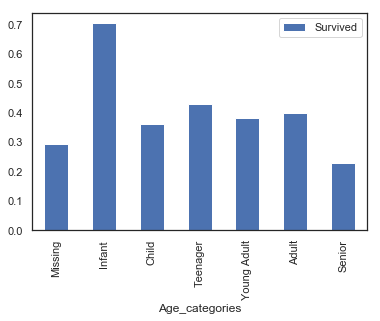

In [107]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]

train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
my_pivot = train.pivot_table(index="Age_categories",values="Survived")
my_pivot.plot.bar()

#### This makes the intuition much more obvious by showing a very rate survival rate for infants which will also help my models.

In [108]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")

train = create_dummies(train,"Sex")
test = create_dummies(test,"Sex")

train = create_dummies(train,"Age_categories")
test = create_dummies(test,"Age_categories")

In [109]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior'],
      dtype='object')

In [110]:
train.drop(['Pclass', 'Sex', 'Age', 'Age_categories'], axis=1, inplace=True)

In [111]:
test.drop(['Pclass', 'Sex', 'Age', 'Age_categories'], axis=1, inplace=True)

#### Let's drop those columns because we either don't need them or during one hot encoding always 1 category can be dropped because it can be inferred from the others (e.g. if NOT male .. it has to be female). Less features are better to prevent overfitting because in multidimensional data distances become less and less meaningful.

In [112]:
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
print(train[columns].describe(include='all',percentiles=[]))

             SibSp       Parch        Fare    Cabin Embarked
count   891.000000  891.000000  891.000000      204      889
unique         NaN         NaN         NaN      147        3
top            NaN         NaN         NaN  B96 B98        S
freq           NaN         NaN         NaN        4      644
mean      0.523008    0.381594   32.204208      NaN      NaN
std       1.102743    0.806057   49.693429      NaN      NaN
min       0.000000    0.000000    0.000000      NaN      NaN
50%       0.000000    0.000000   14.454200      NaN      NaN
max       8.000000    6.000000  512.329200      NaN      NaN


#### Now lets take care of missing values and scale the numeric columns because if we will for instance use euclidian distance as a loss function or error measure then the large difference in min and max values between SibSp and Fare (for instance) will cause trouble.

In [113]:
from sklearn.preprocessing import minmax_scale
# The holdout set has a missing value in the Fare column which
# we'll fill with the mean.
test["Fare"] = test["Fare"].fillna(train["Fare"].mean())
test["Embarked"] = test["Embarked"].fillna("S")
train["Embarked"] = train["Embarked"].fillna("S")
train = create_dummies(train, "Embarked")
test = create_dummies(test, "Embarked")

columns = ["SibSp", "Parch", "Fare"]
new_names = ["SibSp_scaled", "Parch_scaled", "Fare_scaled"]

for i, item in enumerate(columns):
    train[new_names[i]] = minmax_scale(train[item])
    test[new_names[i]] = minmax_scale(test[item])                                   

/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


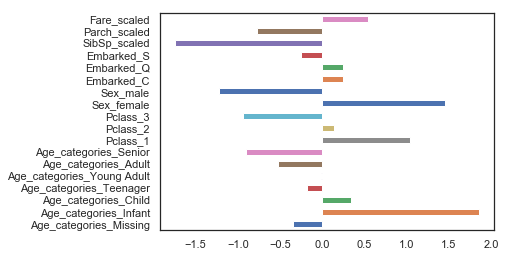

In [114]:
from sklearn.linear_model import LogisticRegression

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

train_X = train[columns]
train_y = train["Survived"]

lr = LogisticRegression()
lr.fit(train_X, train_y)
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0], index=train_X.columns)

feature_importance.plot.barh()

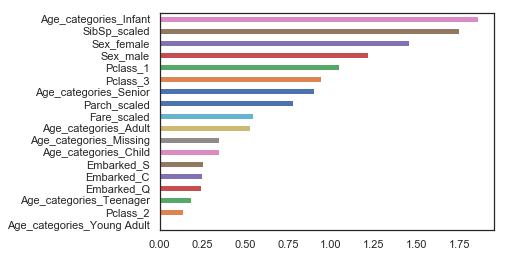

In [115]:
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

#### To start off - let's train this logistics regression model which will give us a first impression how good certain features contribute to a model performance by extracting the coefficients. This is meaningful since everything is scaled between 0 and 1.

In [116]:
features = list(ordered_feature_importance.index[-10:])
features

['Age_categories_Adult',
 'Fare_scaled',
 'Parch_scaled',
 'Age_categories_Senior',
 'Pclass_3',
 'Pclass_1',
 'Sex_male',
 'Sex_female',
 'SibSp_scaled',
 'Age_categories_Infant']

#### Let's train this with the top 10 features and get an impression how good the model is

In [117]:
from sklearn.model_selection import cross_val_score

columns = features

train_X = train[columns]
train_y = train["Survived"]

lr = LogisticRegression()
scores = cross_val_score(lr, train_X, train_y,cv=10)
accuracy = scores.mean()
print("The model accuracy with cross validation is {}".format(accuracy))

The model accuracy with cross validation is 0.811418681193962


/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/linea

In [118]:
lr.fit(train_X, train_y)
test_predictions = lr.predict(test[columns])

/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [119]:
submission1 = pd.concat([test["PassengerId"], pd.Series(test_predictions)], axis=1)
submission1.columns = ["PassengerId", "Survived"]
submission1.to_csv("submission.csv",index=False)

#### Checking now on Kaggle.com gets around 77%.

#### We haven't looked at names. Names are probably not telling to much we don't already now (like gender) but maybe about social status which might contribute to survival. 

In [120]:
train["Name"].head(15)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
Name: Name, dtype: object

In [121]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Mr",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)
extracted_titles = test["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
test["Title"] = extracted_titles.map(titles)       

In [122]:
test = create_dummies(test, "Title")
train = create_dummies(train, "Title")

In [123]:
test.drop(["Title"], axis = 1, inplace=True)
train.drop(["Title"], axis = 1, inplace=True)

#### Now Collinearity check

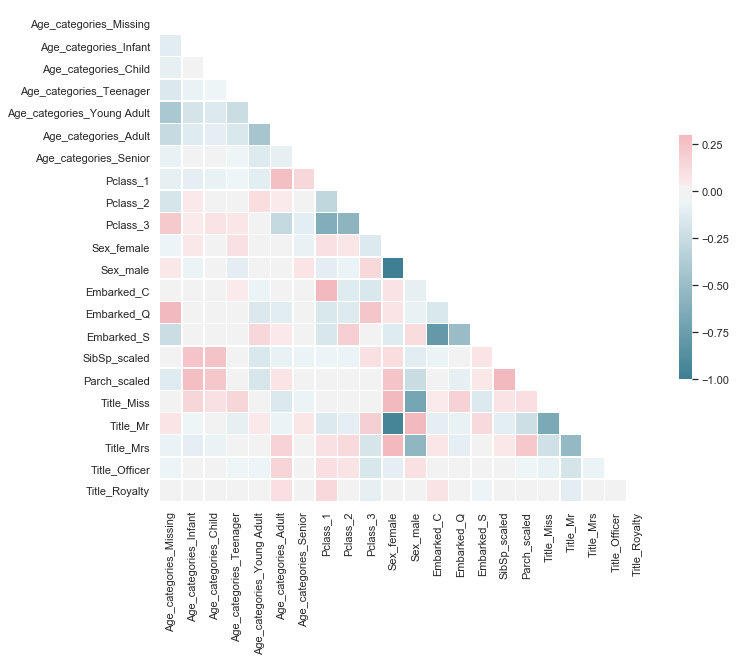

In [124]:
import numpy as np
import seaborn as sns

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled',
       'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty']

plot_correlation_heatmap(train[columns])

In [125]:
train.head()

,PassengerId,Survived,Name,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,...,Embarked_Q,Embarked_S,SibSp_scaled,Parch_scaled,Fare_scaled,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,1,0,"Braund, Mr. Owen Harris",1,0,A/5 21171,7.2500,NaN,S,0,...,0,1,0.125,0.0,0.014151,0,1,0,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,71.2833,C85,C,1,...,0,0,0.125,0.0,0.139136,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,7.9250,NaN,S,0,...,0,1,0.000,0.0,0.015469,1,0,0,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,113803,53.1000,C123,S,1,...,0,1,0.125,0.0,0.103644,0,0,1,0,0
4,5,0,"Allen, Mr. William Henry",0,0,373450,8.0500,NaN,S,0,...,0,1,0.000,0.0,0.015713,0,1,0,0,0


In [126]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled',
       'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', "Fare"]

train_X = train[columns]
train_y = train["Survived"]

lr = LogisticRegression()
scores = cross_val_score(lr, train_X, train_y,cv=10)
accuracy = scores.mean()
print("The model accuracy with cross validation is {}".format(accuracy))

The model accuracy with cross validation is 0.818223243672682


/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/linea

#### slight improvement by 0.07 points ... 

In [127]:
train.columns

Index(['PassengerId', 'Survived', 'Name', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female',
       'Sex_male', 'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty'],
      dtype='object')

In [128]:
drop_these_cols = ["Pclass_2",
    "Age_categories_Teenager",
    "Sex_male",
    "Title_Mr", "Embarked_C"]
test.drop(drop_these_cols, axis = 1, inplace=True)
train.drop(drop_these_cols, axis = 1, inplace=True)

#### ...now removed one of each of my dummy variables to reduce the collinearity in each

#### ...let's gather now all relevant features

In [129]:
train.columns

Index(['PassengerId', 'Survived', 'Name', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Pclass_1', 'Pclass_3', 'Sex_female',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Embarked_Q',
       'Embarked_S', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled',
       'Title_Miss', 'Title_Mrs', 'Title_Officer', 'Title_Royalty'],
      dtype='object')

# Let's now start trying some models

In [130]:
feature_columns = ['Fare',
       'Pclass_1', 'Pclass_3', 'Sex_female',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior',
       'Embarked_Q', 'Embarked_S', 'SibSp_scaled', 'Parch_scaled',
       'Fare_scaled', 'Title_Miss', 'Title_Mrs', 'Title_Officer',
       'Title_Royalty']

train_X = train[feature_columns]
train_y = train["Survived"]

all_scores = {}

## 1. Machine Learning

### a) kNN

In [131]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

knn = KNeighborsClassifier(n_neighbors=1)
scores = cross_val_score(knn, train_X, train_y, cv=10)
accuracy_knn = np.mean(scores)

In [132]:
accuracy_knn

0.7352755078878674

In [133]:
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}

grid = GridSearchCV(knn, param_grid=hyperparameters, cv=10)
grid.fit(train_X,train_y)

best_params = grid.best_params_
best_score = grid.best_score_

/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [134]:
best_score

0.7890011223344556

In [135]:
best_params

{'algorithm': 'brute', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}

In [136]:
all_scores["knn"] = best_score

In [137]:
predictions = best_model.predict(test[feature_columns])
submission = pd.concat([test["PassengerId"], pd.Series(predictions)], axis=1)
submission.columns = ["PassengerId", "Survived"]
submission.to_csv("submission_knn.csv", index=False)

### b) Logistics Regression

In [138]:
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(solver='liblinear')
scores = cross_val_score(lr, train_X, train_y,cv=10)
accuracy = scores.mean()
print("The model accuracy with cross validation is {}".format(accuracy))

The model accuracy with cross validation is 0.8215940301895358


In [139]:
hyperparameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], "solver":['newton-cg', 'liblinear']}

grid = GridSearchCV(lr, param_grid=hyperparameters, cv=10)
grid.fit(train_X,train_y)

best_params = grid.best_params_
best_score = grid.best_score_

/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [140]:
best_score

0.8215488215488216

In [141]:
best_params

{'C': 1, 'solver': 'liblinear'}

In [142]:
all_scores["LogReg"] = best_score

In [143]:
predictions = best_model.predict(test[feature_columns])
submission = pd.concat([test["PassengerId"], pd.Series(predictions)], axis=1)
submission.columns = ["PassengerId", "Survived"]
submission.to_csv("submission_LR.csv", index=False)

### c) Random Forest

In [144]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

clf = RandomForestClassifier(random_state=1)

scores = cross_val_score(clf, train_X, train_y, cv=10)
accuracy_rf = np.mean(scores)

/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.2

In [145]:
accuracy_rf

0.8115066394279878

In [146]:
hyperparameters = {"criterion": ["entropy", "gini"],
                   "max_depth": [2, 5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5],
                   "min_samples_split": [3, 5],
                   "n_estimators": [6, 9]
}

clf = RandomForestClassifier()
grid = GridSearchCV(clf, param_grid=hyperparameters, cv=10)
grid.fit(train_X,train_y)
                   
                    

best_params = grid.best_params_
best_score = grid.best_score_
best_model = grid.best_estimator_

/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [147]:
best_score

0.8294051627384961

In [148]:
all_scores["Random Forest"] = best_score

In [149]:
predictions = best_model.predict(test[feature_columns])
submission = pd.concat([test["PassengerId"], pd.Series(predictions)], axis=1)
submission.columns = ["PassengerId", "Survived"]
submission.to_csv("submission_RandomForest.csv", index=False)

### d) SVM

In [150]:
from sklearn import svm

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
hyperparameters = {'C': Cs, 'gamma' : gammas}

clf = svm.SVC(gamma='scale')
grid = GridSearchCV(clf, param_grid=hyperparameters, cv=10)
grid.fit(train_X,train_y)

best_params = grid.best_params_
best_score = grid.best_score_
best_model = grid.best_estimator_

/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [151]:
all_scores["SVM"] = best_score

In [152]:
predictions = best_model.predict(test[feature_columns])
submission = pd.concat([test["PassengerId"], pd.Series(predictions)], axis=1)
submission.columns = ["PassengerId", "Survived"]
submission.to_csv("submission_SVM.csv", index=False)

## 2. Deep Learning

### a) Perceptron

In [153]:
from sklearn.linear_model import Perceptron

In [154]:
iterations=50
jobs=10

hyperparameters = {"alpha": np.linspace(0,2,5),"n_jobs": np.arange(1,10,2), "tol": np.arange(1,10,2) }

clf = Perceptron()
grid = GridSearchCV(clf, param_grid=hyperparameters, cv=10)
grid.fit(train_X,train_y)

best_params = grid.best_params_
best_score = grid.best_score_
best_model = grid.best_estimator_

/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [155]:
all_scores["Perceptron"] = best_score

In [156]:
predictions = best_model.predict(test[feature_columns])
submission = pd.concat([test["PassengerId"], pd.Series(predictions)], axis=1)
submission.columns = ["PassengerId", "Survived"]
submission.to_csv("submission_Perceptron.csv", index=False)

### b) Feed Forward Network

In [157]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

/Users/Max/anaconda3/envs/maxisses_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [158]:
dimensions = len(train_X.columns)
dimensions

19

In [159]:
all_scores

{'knn': 0.7890011223344556,
 'LogReg': 0.8215488215488216,
 'Random Forest': 0.8294051627384961,
 'SVM': 0.7957351290684624,
 'Perceptron': 0.6902356902356902}

In [174]:
predictions = [0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0]
submission = pd.concat([test["PassengerId"], pd.Series(predictions)], axis=1)
submission.columns = ["PassengerId", "Survived"]
submission.to_csv("submission_Keras.csv", index=False)

In [ ]:
keras : 0.76076
knn: 0.72727
LR: 0.72727
perceptron: 0.39234
Random Forest: 0.77033
SVM = 0.72727